# Rover Homework

### Import

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Circle
from scipy.io import loadmat
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline
import pickle
import os
import sympy as sp
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import make_interp_spline
# from Library.load_maps import load_maps
from Library.get_indices import get_indices
from Library.get_indices import get_point
from Library.obstacles_check import obstacles_check
from Library.kinematicModel import kinematicModel
from Library.move2pose import move2pose
from Library.pose2polar import pose2polar
from Library.polar2pose import polar2pose
from Library.A_star_without_reopening import A_star_without_reopening
from Library.EKF import EKF
from Library.dead_reckoning import dead_reckoning
from Library.dead_reckoning import compute_and_plot_ellipses

# from rich.traceback import install
# install(show_locals = True)

### First plots

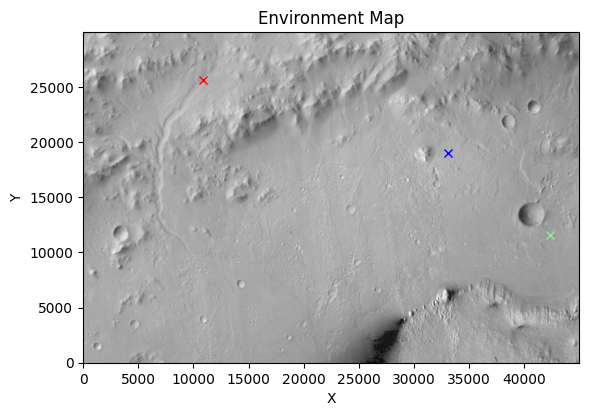

In [2]:
# Set Options
np.set_printoptions(floatmode='fixed', precision=3, suppress=True)

# X, Y, env_map, obstacleMap, xLM, yLM, Xvec, Yvec = load_maps()
# Load the .mat file
filename = 'exercise.mat'
data = loadmat(filename)
# Extract the variables from the loaded data
X = data['X']
Y = data['Y']
env_map = data['map']
obstacleMap = data['obstacleMap']
xLM = data['xLM']
yLM = data['yLM']
Xvec = data['Xvec']
Yvec = data['Yvec']

# Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> remove unnecessary dimension and comvert them in 1D arrays
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Poses
P_0 = np.array([42380, 11590, np.pi/2])  # m, m, rad
P_1 = np.array([33070, 19010, np.pi])    # m, m, rad
P_2 = np.array([10870, 25670])    # m, m

# Show Environment Map
plt.figure("Environment Map")
plt.title("Environment Map")
# library.plot_map(map_image, Xvec, Yvec)
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.xlabel('X')
plt.ylabel('Y')

# Plot on the environment map the starting position and the goal positions of the robot
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
plt.plot(P_2[0], P_2[1], color='red', marker='x', markersize=6)
# plt.savefig('environment_map_with_positions.png', dpi = 300)
plt.show()

# #NOT SURE THEY ARE NEEDED NOW
# # Show obstacle map
# plt.figure()
# plt.imshow(obstacleMap, cmap='gray',  extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

# # Show landmarks map
# plt.figure()
# plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
# plt.grid(True)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
# plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
# plt.show()

## Task 1: Navigation - Moving to a Pose MODIFY THIS

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows: K = [1e-4, 1.4e-3, -1.8e-3]

In [3]:
# Compute Relative States
Polar0 = pose2polar(P_0, P_1)
Polar1 = pose2polar(P_1, P_1)

# Convert backwards the Relative State into Pose State
# P_0p = polar2pose(R0, P_1)

P_0_str = [f"{x:.2f}".ljust(10) for x in P_0]
Polar0_str = [f"{x:.2f}".ljust(10) for x in Polar0]
Polar1_str = [f"{x:.2f}".ljust(10) for x in Polar1]

print('\nThe Initial Pose State is:\n',' '.join(P_0_str))
print('\nThe Polar State is:\n',' '.join(Polar0_str))
# print("\nThe Backconverted Initial Pose State is P_0':\n", P_0p)

# Stop function for the integration
# the integration will stop when the robot will reach a distance from the goal position of rho_tol meters
rho_tol = 0.001    # m
def event(t, current_state):
    return current_state[0] - rho_tol
event.terminal = True

# Time Domain
# Initial start time in seconds
t0 = 0 
# Maximum manoeuvre time -> 30 days in seconds
tf = 30 * 24 * 60**2
# Sampling frequency of the trajectory in Hz
freq = 0.1
# tspan generation at given sampling frequency
tspan = np.arange(t0, tf+1, 1/freq)


# Gains [Krho Kalpha Kbeta]
K = np.array([1, 1.48, -1.9])
# res = 1.48e-3 - 1e-3
# print(res)

# Define global variables to store v and omega
v_values = []
omega_values = []
alpha_values = []

# Define a wrapper function for solve_ivp
def wrapper(t, current_state, K, v_values, omega_values, alpha_values):
    dS, v_values, omega_values, alpha_values = kinematicModel(t, current_state, K, v_values, omega_values, alpha_values)
    return dS

# Solve the differential equation
sol = solve_ivp(lambda t, current_state: wrapper(t, current_state, K,  v_values, omega_values, alpha_values), [t0, tf], Polar0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
current_state = sol.y
P_final = polar2pose(current_state, P_1)
# Print v and omega
print("v values:", v_values[-1])
print("omega values:", omega_values[-1])
# print("alpha values:", alpha_values)

# Check for Obstacles
P_indices = np.array([get_indices(P_final[0:2, i], X, Y, mapRes) for i in range(P_final.shape[1])])    # convert each point in the trajectory to map indices
if obstacles_check(P_indices, obstacleMap):
    print('\n\nThe Trajectory intersects with an Obstacle!\n\n')

P_1r = P_final[:, -1]      # store the real final state of the robot for the next task



The Initial Pose State is:
 42380.00   11590.00   1.57      

The Polar State is:
 11905.15   0.90       0.67      
v values: 0.0005931287937860949
omega values: 3.406512339334139e-08


### Display of the results

In [4]:
# Convert the numbers to strings with a certain width and 2 decimal places just for display purposes
P_0_str = [f"{x:.3f}".ljust(10) for x in P_0]
P_final_str = [f"{x:.3f}".ljust(10) for x in P_final[:, -1]]
P_1_str = [f"{x:.3f}".ljust(10) for x in P_1]
error_str = [f"{x:.3f}".ljust(10) for x in P_final[:, -1] - P_1]

# Log Results
print('Initial state:\t', ' '.join(P_0_str), 'm, m, rad')
print('Final state is:\t', ' '.join(P_final_str), 'm, m, rad')
print('Desired state:\t', ' '.join(P_1_str), 'm, m, rad')
print('\nError:\t', ' '.join(error_str), 'm, m, rad')
print('Final Time: {:.3f} seconds\n'.format(tspan[-1]),'equal to: {:.3f} days'.format(tspan[-1]/ (24 * 60**2)))

Initial state:	 42380.000  11590.000  1.571      m, m, rad
Final state is:	 33070.021  19010.000  3.142      m, m, rad
Desired state:	 33070.000  19010.000  3.142      m, m, rad

Error:	 0.021      0.000      0.000      m, m, rad
Final Time: 331330.000 seconds
 equal to: 3.835 days


### Plot of the trajectory in the environment map

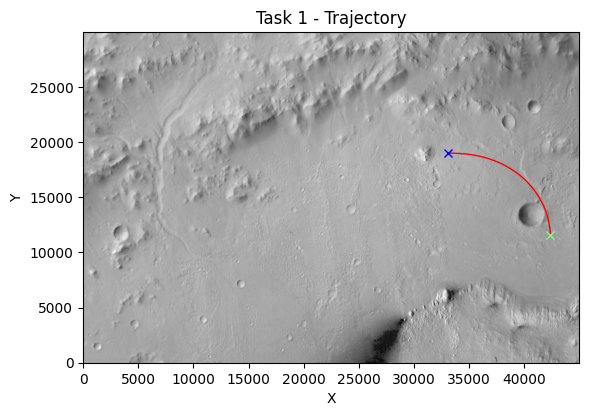

In [21]:
# Environment map with trajectory
plt.figure("Task 1 - Trajectory")
plt.title("Task 1 - Trajectory")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(P_final[0, :], P_final[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
# plt.savefig('Task1_env.png', dpi = 300)

# # animation of the trajectory
# fig, ax = plt.subplots()

# # Set up the plot elements
# plt.title("Task 1 - Trajectory")
# plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.axis('on')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.plot(P_0[0], P_0[1], 'gx', markersize=6)
# plt.plot(P_1[0], P_1[1], 'bx', markersize=6)

# # Create a line object for the trajectory
# line, = ax.plot([], [], 'r', linestyle='-', linewidth=1)

# # Initialization function for the animation
# def init():
#     line.set_data([], [])
#     return line,

# # Animation function. This is called sequentially
# def animate(i):
#     x = P[0, :i]
#     y = P[1, :i]
#     line.set_data(x, y)
#     return line,

# matplotlib.rcParams['animation.embed_limit'] = 2**128  # or any large number
# # Create the animation
# ani = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0, len(P[0]), 2), interval=10, blit=True)
# ani.save('Task1.mp4', writer='ffmpeg')


# plt.show()

### Plot of the trajectory in the obstacle map
to show that it doesn't collide with obstacles

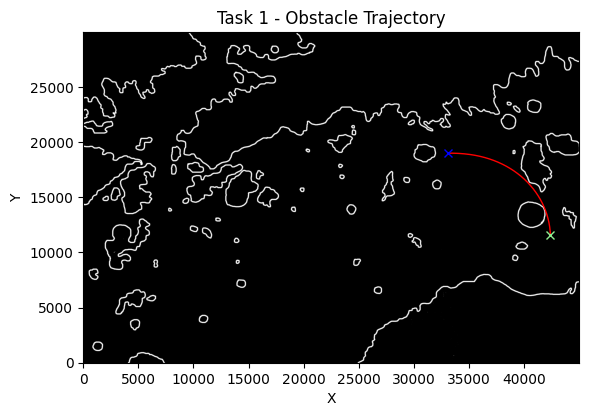

In [22]:
# Obstacle map with trajectory
plt.figure("Task 1 - Obstacle Trajectory")
plt.title("Task 1 - Obstacle Trajectory")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P_final[0, :], P_final[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
plt.xlabel('X')
plt.ylabel('Y')
# plt.savefig('Task1_obs.png', dpi = 300)
plt.show()

## Task 2: Path Planning - A* Algorithm
initialization and plot of the start and goal position of the task

Start:	 33070.021  19010.000 
Start:	 10870.000  25670.000 
Start indices:	 [1097 3307]
Goal indices:	 [ 432 1087]


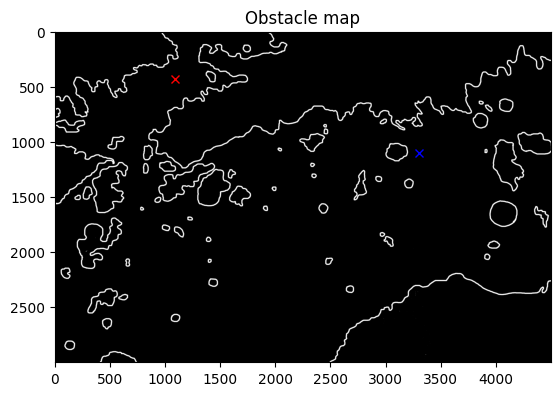

In [4]:
# Start and Goal Coordinates
# the start is the stored value of the real final state of the robot from the previous task
A_star_start = P_1r[0:2]
# the goal is the previously defined P_2
A_star_goal = np.array([P_2[0], P_2[1]])

A_star_start_str = [f"{x:.3f}".ljust(10) for x in A_star_start]
A_star_goal_str = [f"{x:.3f}".ljust(10) for x in A_star_goal]
print('Start:\t', ' '.join(A_star_start_str))
print('Start:\t', ' '.join(A_star_goal_str))

#convert the positions in map indices (pixels) since A* will need pixels to find a path
A_star_start_ind = get_indices(A_star_start, X, Y, mapRes)
A_star_goal_ind = get_indices(A_star_goal, X, Y, mapRes)

#display the values of the start and goal coordinates
print('Start indices:\t', A_star_start_ind)
print('Goal indices:\t', A_star_goal_ind)

# Obstacle map with start and goal coordinates
plt.figure("Obstacle map")
plt.title("Obstacle map")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
# plt.savefig('obstacle_map_with_positions.png', dpi = 300)
plt.show()

## IF A* WAS NEVER RUN BEFORE

### Compute the path with A*

In [5]:
# find the path using A* algorithm
path = A_star_without_reopening(A_star_start_ind, A_star_goal_ind, obstacleMap)          
# convert to matrix
path = np.array(path)

Finding path:   0%|          | 0/1 [00:00<?, ?step/s]

Finding path: 2754205step [46:16, 992.12step/s]      


### Plot the A* path

The size of the retrieved path is: 6148


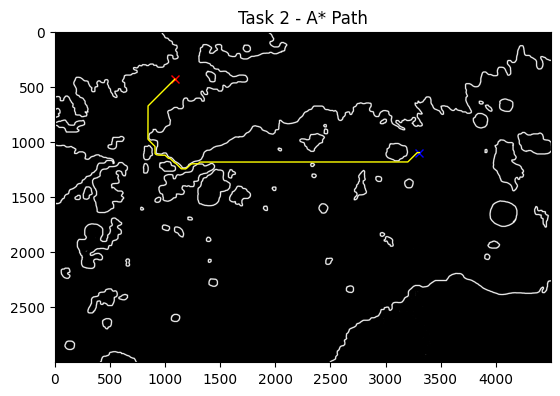

In [6]:
np.save('path.npy', path)
print('The size of the retrieved path is:', path.size)
# Plot the Path
plt.figure("Task 2 - Pathfinding")
plt.title("Task 2 - A* Path")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], 'bx', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], 'rx', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)
# plt.savefig('A_star_path.png', dpi = 300)
plt.show()

## IF A* PATH IS ALREADY IN THE DATA FOLDER

### Load the path and plot it

In [12]:
# data = np.load('Data/path1minusSqrt.npy')  #remenmber to change the name of the file
# path1 = np.array(data)

# data = np.load('Data/pathSqrt.npy')  #remenmber to change the name of the file
# path2 = np.array(data)

# are_equal = np.array_equal(path1, path2)

# print(are_equal)

# are_close = np.allclose(path1, path2)
# print(are_close)

False
False


## DEPENDS ON THE HEURISTIC CHOSEN
Just $\sqrt2$ used

The size of the retrieved path is: 6148


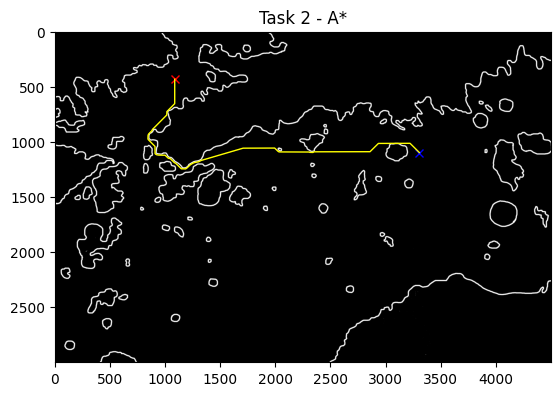

In [78]:
data = np.load('Data/path_sqrt2_withcost.npy')  #remenmber to change the name of the file
path = np.array(data)
print('The size of the retrieved path is:', path.size)
plt.figure("Task 2")
plt.title("Task 2 - A*")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)
plt.show()

$\sqrt2 -1$ used

The size of the retrieved path is: 6148


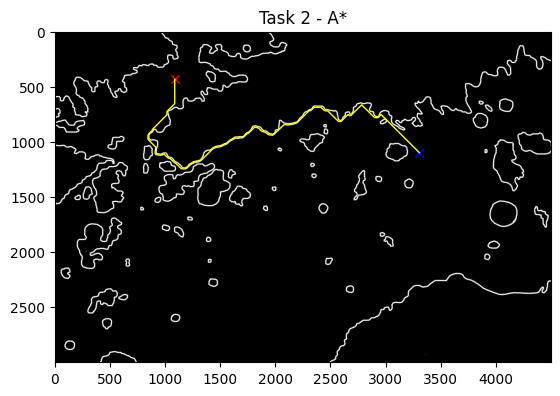

In [13]:
data = np.load('Data/pathSqrt_minus1_withcost.npy')
path = np.array(data)
print('The size of the retrieved path is:', path.size)
plt.figure("Task 2")
plt.title("Task 2 - A*")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)
plt.show()

## Conversion from indeces to coordinates

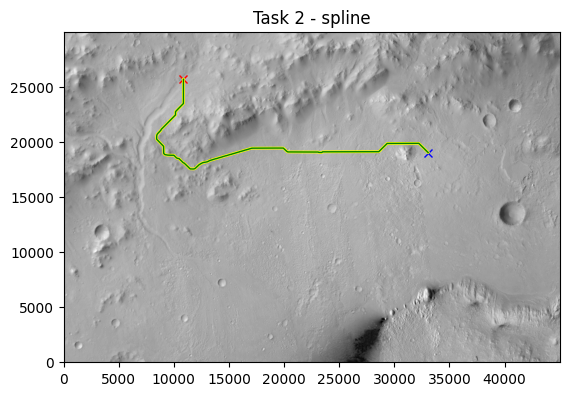

In [79]:
#convert the path from indices to coordinates
path_coords = [get_point(indices, X, Y, mapRes) for indices in path]
path_coords = np.array(path_coords)

# Array of indices
indices = np.arange(len(path_coords))

# 5th degree polynomial interpolations
spl_x = UnivariateSpline(indices, path_coords[:, 0], k=5, s=1)
spl_y = UnivariateSpline(indices, path_coords[:, 1], k=5, s=1)

# Set of indices for the interpolated path
indices_new = np.linspace(indices.min(), indices.max(), 10000000)

# The corresponding x and y values
x_interp = spl_x(indices_new)
y_interp = spl_y(indices_new)

# Collect x_interp and y_interp in a single array
path_interp = np.array([x_interp, y_interp]).T



plt.figure('Task 2 - spline')
plt.title('Task 2 - spline')
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot([A_star_start[0]], [A_star_start[1]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal[0]], [A_star_goal[1]], color='red', marker='x', markersize=6)
plt.plot(path_coords[:, 0], path_coords[:, 1], c='yellow', linestyle='-', linewidth=2)
# Plot the interpolated path
plt.plot(x_interp, y_interp, c='green', linestyle='-', linewidth=1)
# plt.savefig('Task2_spline.png', dpi = 300)
plt.show()

In [80]:
# Calculate the differences between adjacent x and y values
dx = np.diff(path_interp[:, 0])
dy = np.diff(path_interp[:, 1])

# Calculate the angle at each point
angles = np.arctan2(dy, dx)

# Unwrap the angles to produce a smoothly varying angle
angles = np.unwrap(angles)

# Add the starting angle (converted to radians)
start_angle = np.deg2rad(180)
angles = np.concatenate(([start_angle], angles))

#collect the angles in a single array
path_angles_interp = np.array([x_interp, y_interp, angles]).T

print(path_angles_interp)
print(path_angles_interp.shape)


[[33070.000 19019.999     3.142]
 [33069.997 19020.002     2.356]
 [33069.994 19020.005     2.356]
 ...
 [10870.001 25669.994     1.571]
 [10870.001 25669.997     1.571]
 [10870.001 25670.000     1.571]]
(10000000, 3)


## Task 3: Rover Localization
Define Problem Parameters

In [26]:
# Retrieve Trajectory from Task 1
q_real = P_final.T            # N x 3 matrix containing the real pose state at each time step
tspan_real = tspan      # N x 1 array containing the timespan
# print(q_real)

# Define Model Parameters
sigma_x = 6                         # m
sigma_y = 6                         # m
sigma_theta_param = np.deg2rad(1)         # rad

# Define Initial Covariance Matrix
L0 = np.array([[sigma_x**2, 0, 0], [0, sigma_y**2, 0], [0, 0, sigma_theta_param**2]])

# Define Sensor Parameters
sigma_d = 0.004      # m         #odometer distance measurement noise
sigma_theta = np.deg2rad(0.05)      # rad       #odomter heading angle measurement noise

lidar_maxrange=500      #m         # lidar maximum range
sigma_r=0.10       # m         # lidar range measurement noise
sigma_beta=np.deg2rad(0.25)     #rad     # lidar bearing measurement noise


### Perform Dead Reckoning

In [33]:
q_est_dr, L_est_dr = dead_reckoning(q_real, sigma_d, sigma_theta, L0)

sqrt_det_L_dr = [np.sqrt(np.linalg.det(L_dr)) for L_dr in L_est_dr]

Processing: 100%|██████████| 33133/33133 [00:00<00:00, 75478.95it/s]


### Plot of the Path

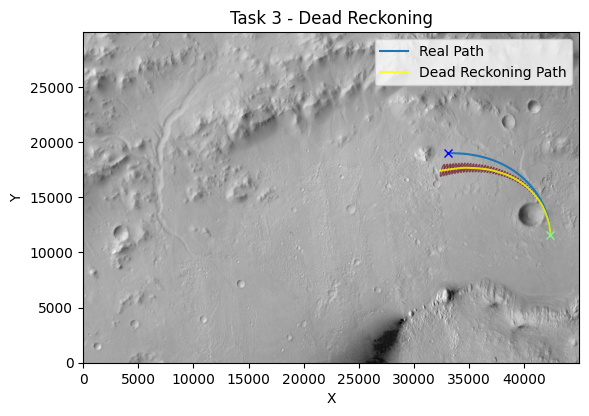

In [34]:
plt.figure("Task 3 - Dead Reckoning")
plt.title("Task 3 - Dead Reckoning")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)

compute_and_plot_ellipses(q_est_dr, L_est_dr, plt, frequency=0.0015)
# plt.savefig('dr_path.png', dpi=300)
plt.show()

### Plot on the obstacle map
to show that avoids slope regions

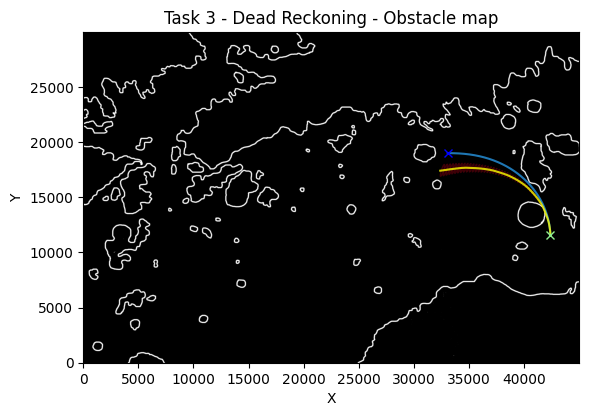

In [35]:
plt.figure("Task 3 - Dead Reckoning - Obstacle map")
plt.title("Task 3 - Dead Reckoning - Obstacle map")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)

compute_and_plot_ellipses(q_est_dr, L_est_dr, plt, frequency=0.0015)
# plt.savefig('dr_path_obs.png', dpi=300)
plt.show()

### Visualize the Covariance Matrix Evolution

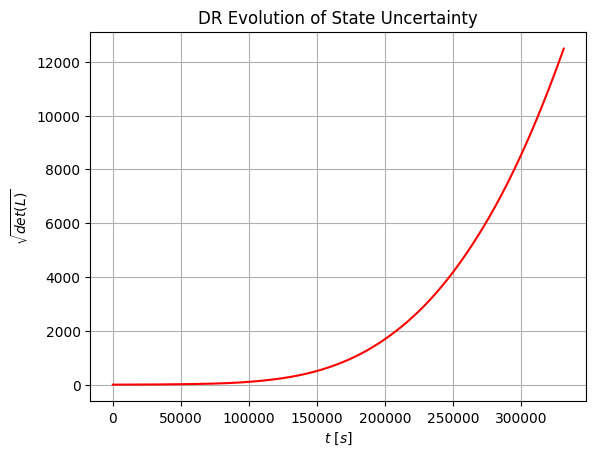

In [36]:
plt.figure("DR Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L_dr, c='red')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('DR Evolution of State Uncertainty')
plt.grid(True)
# plt.savefig('dr_covariancematrix.png', dpi=300)
plt.show()

### Definition of observable functions

$z = h(q, lm) \qquad \qquad H_q = \frac{\partial z}{\partial q}$

### Perform the trajectory reconstruction with the EKF

In [76]:
noise_d_arr = []
noise_theta_arr = []
noise_r_arr= [] 
noise_beta_arr = []

q_est, L_est, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr = EKF(q_real, sigma_d, sigma_theta, L0, lidar_maxrange, sigma_r, sigma_beta, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr, xLM, yLM)

sqrt_det_L = [np.sqrt(np.linalg.det(L)) for L in L_est]


Processing:  28%|██▊       | 9315/33133 [00:02<00:05, 4428.22it/s]

[499.785]
[499.932]
[496.769]
[496.054]
[495.639]
[495.323]
[495.038]
[494.772]
[494.532]
[494.263]
[494.019]
[493.758]
[493.510]
[493.260]
[492.994]
[492.736]
[492.500]
[492.247]
[492.001]
[491.749]
[491.500]
[491.240]
[490.998]
[490.757]
[490.511]
[490.265]
[490.020]
[489.770]
[489.518]
[489.282]
[489.046]
[488.808]
[488.566]
[488.322]
[488.074]
[487.829]
[487.597]
[487.349]
[487.110]
[486.868]
[486.634]
[486.394]
[486.157]
[485.915]
[485.674]
[485.435]
[485.204]
[484.962]
[484.727]
[484.495]
[484.253]
[484.017]
[483.784]
[483.544]
[483.307]
[483.066]
[482.835]
[482.599]
[482.363]
[482.129]
[481.883]
[481.648]
[481.406]
[481.171]
[480.941]
[480.704]
[480.477]
[480.241]
[480.004]
[479.770]
[479.532]
[479.299]
[479.071]
[478.845]
[478.614]
[478.383]
[478.156]
[477.917]
[477.686]
[477.450]
[477.224]
[476.990]
[476.766]
[476.534]
[476.309]
[476.080]
[475.855]
[475.623]
[475.395]
[475.163]
[474.928]
[474.710]
[474.483]
[474.260]
[474.035]
[473.808]
[473.583]
[473.353]
[473.128]
[472.909]


Processing:  33%|███▎      | 11059/33133 [00:02<00:05, 4195.51it/s]

[396.510]
[396.538]
[396.566]
[396.598]
[396.629]
[396.664]
[396.698]
[396.734]
[396.768]
[396.799]
[396.835]
[396.872]
[396.905]
[396.940]
[396.978]
[397.013]
[397.047]
[397.086]
[397.123]
[397.160]
[397.197]
[397.236]
[397.275]
[397.316]
[397.352]
[397.388]
[397.429]
[397.466]
[397.510]
[397.550]
[397.596]
[397.641]
[397.690]
[397.740]
[397.782]
[397.826]
[397.875]
[397.922]
[397.965]
[398.009]
[398.056]
[398.102]
[398.150]
[398.198]
[398.247]
[398.302]
[398.353]
[398.407]
[398.455]
[398.504]
[398.557]
[398.614]
[398.664]
[398.712]
[398.768]
[398.822]
[398.876]
[398.933]
[398.992]
[399.048]
[399.103]
[399.155]
[399.212]
[399.271]
[399.328]
[399.386]
[399.442]
[399.499]
[399.561]
[399.623]
[399.683]
[399.740]
[399.801]
[399.864]
[399.927]
[399.984]
[400.045]
[400.108]
[400.169]
[400.231]
[400.295]
[400.358]
[400.423]
[400.484]
[400.551]
[400.619]
[400.687]
[400.751]
[400.818]
[400.883]
[400.951]
[401.021]
[401.090]
[401.161]
[401.232]
[401.301]
[401.374]
[401.445]
[401.515]
[401.581]


Processing:  64%|██████▍   | 21342/33133 [00:04<00:02, 4241.36it/s]

[499.878]
[499.905]
[447.649]
[442.417]
[440.571]
[439.480]
[438.669]
[438.011]
[437.422]
[436.867]
[436.366]
[435.891]
[435.441]
[434.990]
[434.536]
[434.105]
[433.680]
[433.258]
[432.846]
[432.427]
[432.020]
[431.616]
[431.221]
[430.825]
[430.421]
[430.024]
[429.635]
[429.241]
[428.847]
[428.457]
[428.073]
[427.683]
[427.288]
[426.899]
[426.511]
[426.118]
[425.734]
[425.347]
[424.968]
[424.590]
[424.203]
[423.821]
[423.439]
[423.055]
[422.668]
[422.283]
[421.901]
[421.518]
[421.141]
[420.749]
[420.366]
[419.981]
[419.599]
[419.220]
[418.836]
[418.456]
[418.082]
[417.702]
[417.322]
[416.939]
[416.573]
[416.184]
[415.806]
[415.430]
[415.051]
[414.668]
[414.288]
[413.915]
[413.532]
[413.150]
[412.773]
[412.391]
[412.003]
[411.621]
[411.241]
[410.859]
[410.486]
[410.108]
[409.731]
[409.349]
[408.971]
[408.597]
[408.213]
[407.842]
[407.468]
[407.095]
[406.715]
[406.338]
[405.953]
[405.579]
[405.212]
[404.833]
[404.451]
[404.075]
[403.694]
[403.312]
[402.940]
[402.569]
[402.185]
[401.805]


Processing:  67%|██████▋   | 22180/33133 [00:04<00:02, 3923.98it/s]

[201.544]
[201.237]
[200.930]
[200.619]
[200.317]
[200.016]
[199.714]
[199.403]
[199.095]
[198.791]
[198.479]
[198.184]
[197.881]
[197.574]
[197.266]
[196.970]
[196.673]
[196.377]
[196.081]
[195.780]
[195.473]
[195.177]
[194.875]
[194.581]
[194.280]
[193.981]
[193.682]
[193.383]
[193.082]
[192.785]
[192.487]
[192.192]
[191.899]
[191.609]
[191.318]
[191.027]
[190.738]
[190.442]
[190.159]
[189.864]
[189.568]
[189.280]
[188.987]
[188.691]
[188.404]
[188.113]
[187.820]
[187.531]
[187.247]
[186.957]
[186.668]
[186.377]
[186.093]
[185.801]
[185.520]
[185.226]
[184.937]
[184.656]
[184.374]
[184.092]
[183.807]
[183.525]
[183.248]
[182.967]
[182.692]
[182.412]
[182.128]
[181.847]
[181.566]
[181.279]
[181.006]
[180.739]
[180.463]
[180.193]
[179.913]
[179.636]
[179.360]
[179.081]
[178.808]
[178.528]
[178.252]
[177.983]
[177.702]
[177.431]
[177.164]
[176.889]
[176.609]
[176.342]
[176.079]
[175.807]
[175.540]
[175.265]
[174.995]
[174.714]
[174.453]
[174.181]
[173.927]
[173.667]
[173.406]
[173.140]


Processing:  72%|███████▏  | 23882/33133 [00:05<00:02, 4192.29it/s]

[358.523]
[358.882]
[359.255]
[359.618]
[359.980]
[360.356]
[360.728]
[361.095]
[361.468]
[361.846]
[362.227]
[362.598]
[362.960]
[363.334]
[363.704]
[364.068]
[364.434]
[364.812]
[365.186]
[365.561]
[365.929]
[366.306]
[366.674]
[367.049]
[367.425]
[367.792]
[368.159]
[368.529]
[368.899]
[369.272]
[369.648]
[370.024]
[370.391]
[370.768]
[371.133]
[371.494]
[371.861]
[372.235]
[372.603]
[372.990]
[373.363]
[373.745]
[374.119]
[374.490]
[374.871]
[375.236]
[375.615]
[375.993]
[376.367]
[376.738]
[377.105]
[377.472]
[377.859]
[378.223]
[378.607]
[378.972]
[379.341]
[379.712]
[380.085]
[380.462]
[380.844]
[381.217]
[381.582]
[381.965]
[382.340]
[382.712]
[383.087]
[383.468]
[383.842]
[384.213]
[384.578]
[384.946]
[385.330]
[385.704]
[386.072]
[386.443]
[386.816]
[387.195]
[387.571]
[387.942]
[388.319]
[388.693]
[389.072]
[389.448]
[389.815]
[390.186]
[390.554]
[390.932]
[391.303]
[391.675]
[392.048]
[392.420]
[392.793]
[393.171]
[393.540]
[393.921]
[394.302]
[394.684]
[395.067]
[395.441]


Processing:  82%|████████▏ | 27131/33133 [00:06<00:01, 4600.27it/s]

[499.663]


Processing: 100%|██████████| 33133/33133 [00:07<00:00, 4514.68it/s]


### Plot the estimated trajectory

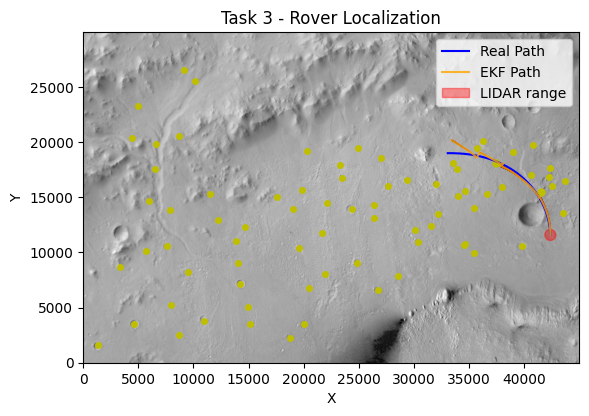

In [77]:
plt.figure("Task 3 - Rover Localization")
plt.title("Task 3 - Rover Localization")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=4, linewidth=1)
plt.plot(xLM[12], yLM[12], 'yo', markersize=5, linewidth=2)
plt.plot(xLM[0], yLM[0], 'yo', markersize=5, linewidth=2)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path', c='Blue')
plt.plot(q_est[:, 0], q_est[:, 1], label='EKF Path', c='orange', linestyle='-', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')

#sow a circle of the radius of the lidar range
circle = Circle((q_est[0, 0], q_est[0, 1]), lidar_maxrange, label='LIDAR range', color='r', fill=True, alpha=0.4)
plt.gca().add_patch(circle)
plt.legend()

compute_and_plot_ellipses(q_est, L_est, plt, frequency=0.01)

plt.savefig('EKF_path.png', dpi=300)
plt.show()

### Visualize the Covariance Matrix Evolution

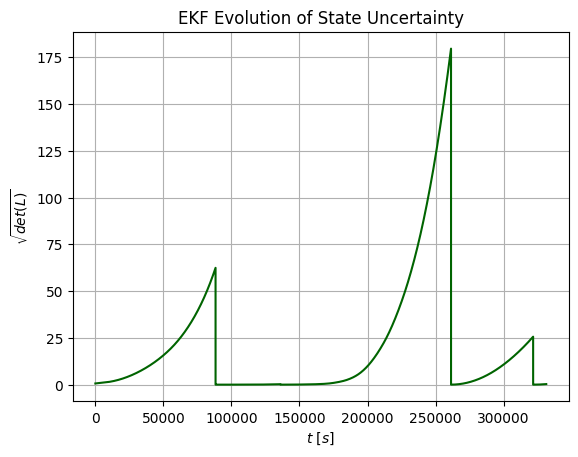

In [7]:
plt.figure("EKF Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L, c='darkgreen')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('EKF Evolution of State Uncertainty')
plt.grid(True)
plt.savefig('EKF_covariancematrix.png', dpi=300)
plt.show()


## Optional

In [81]:
#perform dead reckoning on the path found by A*
q_Astar_est, L_Astar_est, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr = EKF(path_angles_interp, sigma_d, sigma_theta, L0, lidar_maxrange, sigma_r, sigma_beta, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr, xLM, yLM)


sqrt_det_L_Astar_dr = [np.sqrt(np.linalg.det(L_Astar_dr)) for L_Astar_dr in L_Astar_est]

Processing:   2%|▏         | 211846/9999999 [00:45<34:44, 4695.77it/s]


KeyboardInterrupt: 

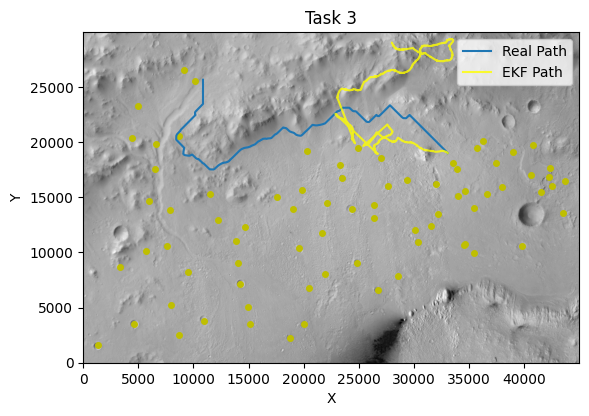

In [17]:
plt.figure("Task 3")
plt.title("Task 3")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=4, linewidth=1)
plt.plot(path_angles_interp[:, 0], path_angles_interp[:, 1], label='Real Path')
plt.plot(q_Astar_est[:, 0], q_Astar_est[:, 1], label='EKF Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# compute_and_plot_ellipses(q_Astar_est_dr, L_Astar_est_dr, plt, frequency=1)

plt.show()